In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from pylab import rcParams

from sklearn.metrics import mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

In [35]:
data = pd.read_csv('../task/student_data.csv', sep =',')
data

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context
0,1,8,653.0,195.0,4324.0,1917829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,50,659.0,198.0,4096.0,1917495.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,89,645.0,149.0,4054.0,1917365.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,128,752.0,213.0,4090.0,1918146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,169,652.0,232.0,4088.0,1919319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824673,48,4225425,NaN,NaN,NaN,NaN,0.0,0.0,-10.0,0.0,NaN,NaN,NaN,NaN
8824674,48,4225455,-808.0,42.0,4038.0,3349663.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824675,48,4225495,-792.0,-89.0,3885.0,3404833.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824676,48,4225535,-806.0,-78.0,4130.0,3316474.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
data.shape
data.info()
data.isna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8824678 entries, 0 to 8824677
Data columns (total 14 columns):
 #   Column        Dtype  
---  ------        -----  
 0   sessionId     int64  
 1   timestamp     int64  
 2   x             float64
 3   y             float64
 4   z             float64
 5   ppgValue      float64
 6   hr            float64
 7   hrIbi         float64
 8   hrStatus      float64
 9   ibiStatus     float64
 10  notification  float64
 11  engagement    float64
 12  affect        object 
 13  context       object 
dtypes: float64(10), int64(2), object(2)
memory usage: 942.6+ MB


,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context
0,False,False,False,False,False,False,True,True,True,True,True,True,True,True
1,False,False,False,False,False,False,True,True,True,True,True,True,True,True
2,False,False,False,False,False,False,True,True,True,True,True,True,True,True
3,False,False,False,False,False,False,True,True,True,True,True,True,True,True
4,False,False,False,False,False,False,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824673,False,False,True,True,True,True,False,False,False,False,True,True,True,True
8824674,False,False,False,False,False,False,True,True,True,True,True,True,True,True
8824675,False,False,False,False,False,False,True,True,True,True,True,True,True,True
8824676,False,False,False,False,False,False,True,True,True,True,True,True,True,True


In [22]:
for col in data:
  num_missing = data[data[col].isna() ==True].shape[0]
  print('Anzahl der NAN-Werte pro Spalte {}: {}'.format(col, num_missing))

Anzahl der NAN-Werte pro Spalte sessionId: 0
Anzahl der NAN-Werte pro Spalte timestamp: 0
Anzahl der NAN-Werte pro Spalte x: 338892
Anzahl der NAN-Werte pro Spalte y: 338892
Anzahl der NAN-Werte pro Spalte z: 338892
Anzahl der NAN-Werte pro Spalte ppgValue: 338892
Anzahl der NAN-Werte pro Spalte hr: 8487003
Anzahl der NAN-Werte pro Spalte hrIbi: 8487003
Anzahl der NAN-Werte pro Spalte hrStatus: 8487003
Anzahl der NAN-Werte pro Spalte ibiStatus: 8487003
Anzahl der NAN-Werte pro Spalte notification: 8824306
Anzahl der NAN-Werte pro Spalte engagement: 8824306
Anzahl der NAN-Werte pro Spalte affect: 8824438
Anzahl der NAN-Werte pro Spalte context: 8824445


In [23]:
data.describe()

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement
count,8.824678e+06,8.824678e+06,8.485786e+06,8.485786e+06,8.485786e+06,8.485786e+06,337675.000000,337675.000000,337675.000000,337675.000000,372.0,372.0
mean,3.243961e+01,3.509351e+06,-5.859700e+02,-2.246576e+03,8.656262e+02,2.059270e+06,47.162639,767.086509,-3.529521,0.286823,1.0,1.0
std,1.618591e+01,2.288202e+06,2.093514e+03,1.602237e+03,2.053281e+03,2.554720e+05,41.084118,535.460339,6.400345,0.452279,0.0,0.0
min,1.000000e+00,0.000000e+00,-3.275700e+04,-3.275800e+04,-3.275800e+04,-6.043650e+05,0.000000,0.000000,-999.000000,0.000000,1.0,1.0
25%,1.900000e+01,1.610097e+06,-2.298000e+03,-3.497000e+03,-3.080000e+02,1.987464e+06,0.000000,394.000000,-10.000000,0.000000,1.0,1.0
50%,3.500000e+01,3.220053e+06,-2.510000e+02,-2.552000e+03,8.390000e+02,2.079625e+06,71.000000,592.000000,1.000000,0.000000,1.0,1.0
75%,4.500000e+01,5.143988e+06,7.870000e+02,-1.255000e+03,2.438000e+03,2.155102e+06,82.000000,960.000000,1.000000,1.000000,1.0,1.0
max,5.800000e+01,9.360487e+06,3.266700e+04,3.276300e+04,3.276400e+04,4.195641e+06,127.000000,3107.000000,1.000000,1.000000,1.0,1.0


In [36]:
#filtered_df = data.dropna(how = "all", subset=['affect', 'context']) 
#filtered_df

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context
13023,1,503234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RELAXED,NaN
13173,1,509006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WALKING
69440,1,2689934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RELAXED,NaN
69715,1,2700529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CONVERSATION
97876,1,3788764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RELAXED,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8008986,58,2595091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAPPY,NaN
8009183,58,2602657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CONVERSATION
8061087,58,4610020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAPPY,NaN
8101818,58,6185055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAPPY,NaN


In [19]:
cleaned_data = data.dropna(thresh=6, axis=0).drop(0).fillna(np.nan) # Thresh =4 bedeutet, dass minimal 4 Werte von den NAN-Werte verschieden sind.
cleaned_data

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context
1,1,50,659.0,198.0,4096.0,1917495.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,89,645.0,149.0,4054.0,1917365.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,128,752.0,213.0,4090.0,1918146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,169,652.0,232.0,4088.0,1919319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,209,582.0,210.0,4093.0,1920154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824673,48,4225425,NaN,NaN,NaN,NaN,0.0,0.0,-10.0,0.0,NaN,NaN,NaN,NaN
8824674,48,4225455,-808.0,42.0,4038.0,3349663.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824675,48,4225495,-792.0,-89.0,3885.0,3404833.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824676,48,4225535,-806.0,-78.0,4130.0,3316474.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#abgabe = pd.read_csv('../task/student_skeleton.csv', sep =',')
#abgabe

In [6]:
#info = pd.read_csv('../task/session_info.csv', sep =',')
#info

,id,duration,watchId,age,gender,fairNumber
0,1,8021351,0Q3V,18-25,female,1
1,2,3752526,0Q3V,26-30,male,1
2,3,3989497,0QED,18-25,male,1
3,4,4979198,0QED,18-25,male,1
4,5,4836199,0QVM,18-25,male,1
5,6,4677432,0RQF,18-25,male,1
6,7,4982640,0RQF,18-25,male,1
7,8,4052272,0V7D,18-25,male,1
8,9,7062503,0V7D,18-25,male,1
9,10,4678102,0VBR,18-25,male,1


## Die preprocessed Daten --> Korrelationsmatrix und Pairplots 

In [8]:
data_cleaned = pd.read_csv('../task/preprocessed_student_data.csv', sep =',')
data_cleaned.head()

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context,timestamp_seconds
0,1,265519,-0.900336,-0.818680,-0.929223,-1.357665,-1.705613,-1.157861,-10.0,1.0,NaN,NaN,RELAXED,NaN,265.519
1,1,265559,-0.974493,-0.864809,-0.873521,-1.358288,-1.705613,-1.157861,-10.0,1.0,NaN,NaN,RELAXED,NaN,265.559
2,1,265600,-0.970043,-0.956506,-0.912270,-1.358733,-1.705613,-1.157861,-10.0,1.0,NaN,NaN,RELAXED,NaN,265.600
3,1,265639,-0.955212,-0.945255,-0.940727,-1.357803,-1.705613,-1.157861,-10.0,1.0,NaN,NaN,RELAXED,NaN,265.639
4,1,265680,-0.993773,-0.925565,-1.017014,-1.356774,-1.705613,-1.157861,-10.0,1.0,NaN,NaN,RELAXED,NaN,265.680


In [3]:
data_cleaned.shape
data_cleaned.info()
data_cleaned.isna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2996054 entries, 0 to 2996053
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   sessionId          int64  
 1   timestamp          int64  
 2   x                  float64
 3   y                  float64
 4   z                  float64
 5   ppgValue           float64
 6   hr                 float64
 7   hrIbi              float64
 8   hrStatus           float64
 9   ibiStatus          float64
 10  notification       float64
 11  engagement         float64
 12  affect             object 
 13  context            object 
 14  timestamp_seconds  float64
dtypes: float64(11), int64(2), object(2)
memory usage: 342.9+ MB


,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context,timestamp_seconds
0,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False
1,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False
2,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False
3,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False
4,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996049,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False
2996050,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False
2996051,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False
2996052,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False


/home/d_mikasa/.virtualenvs/Exercise Sheet/lib/python3.10/site-packages/sklearn/utils/_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/home/d_mikasa/.virtualenvs/Exercise Sheet/lib/python3.10/site-packages/sklearn/utils/_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


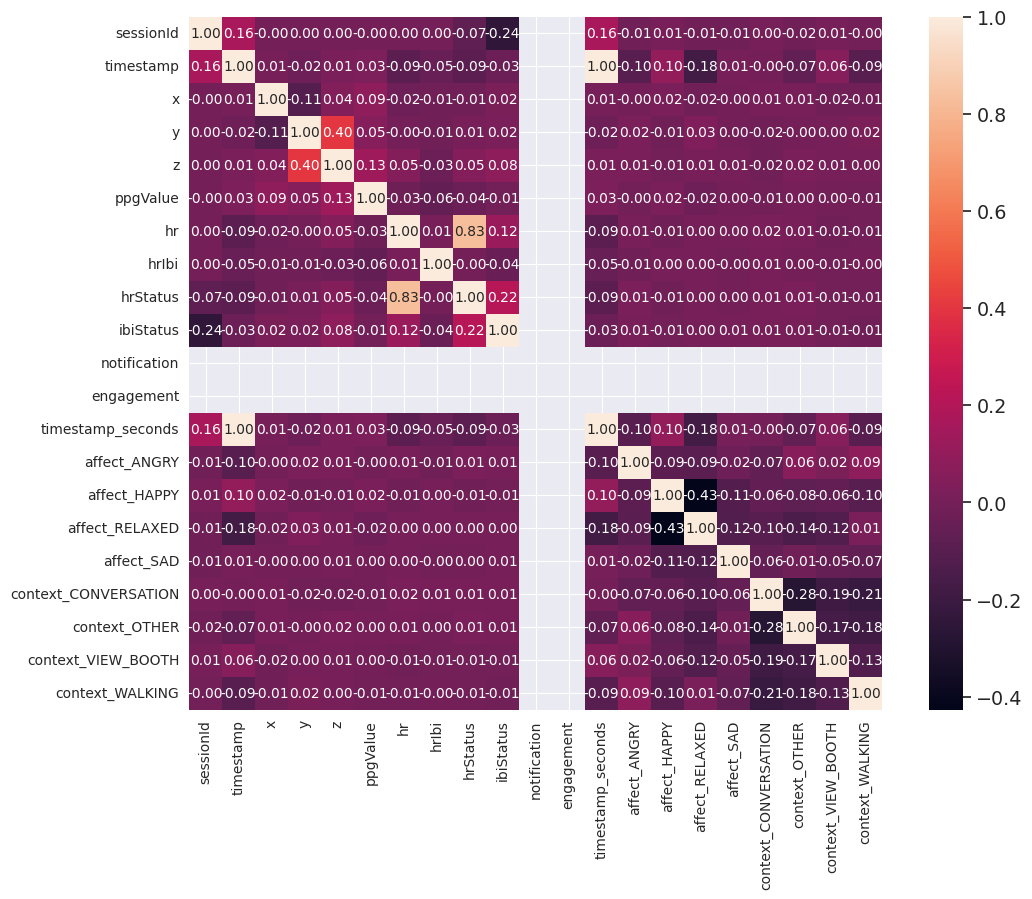

In [3]:
data_encoded = pd.get_dummies(data_cleaned)
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_encoded), columns=data_encoded.columns)
corrmat = data_encoded.corr()

# Erstellen Sie die Heatmap
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
sns.heatmap(corrmat, cbar=True, square=True, annot=True,fmt='.2f', annot_kws={'size': 10});

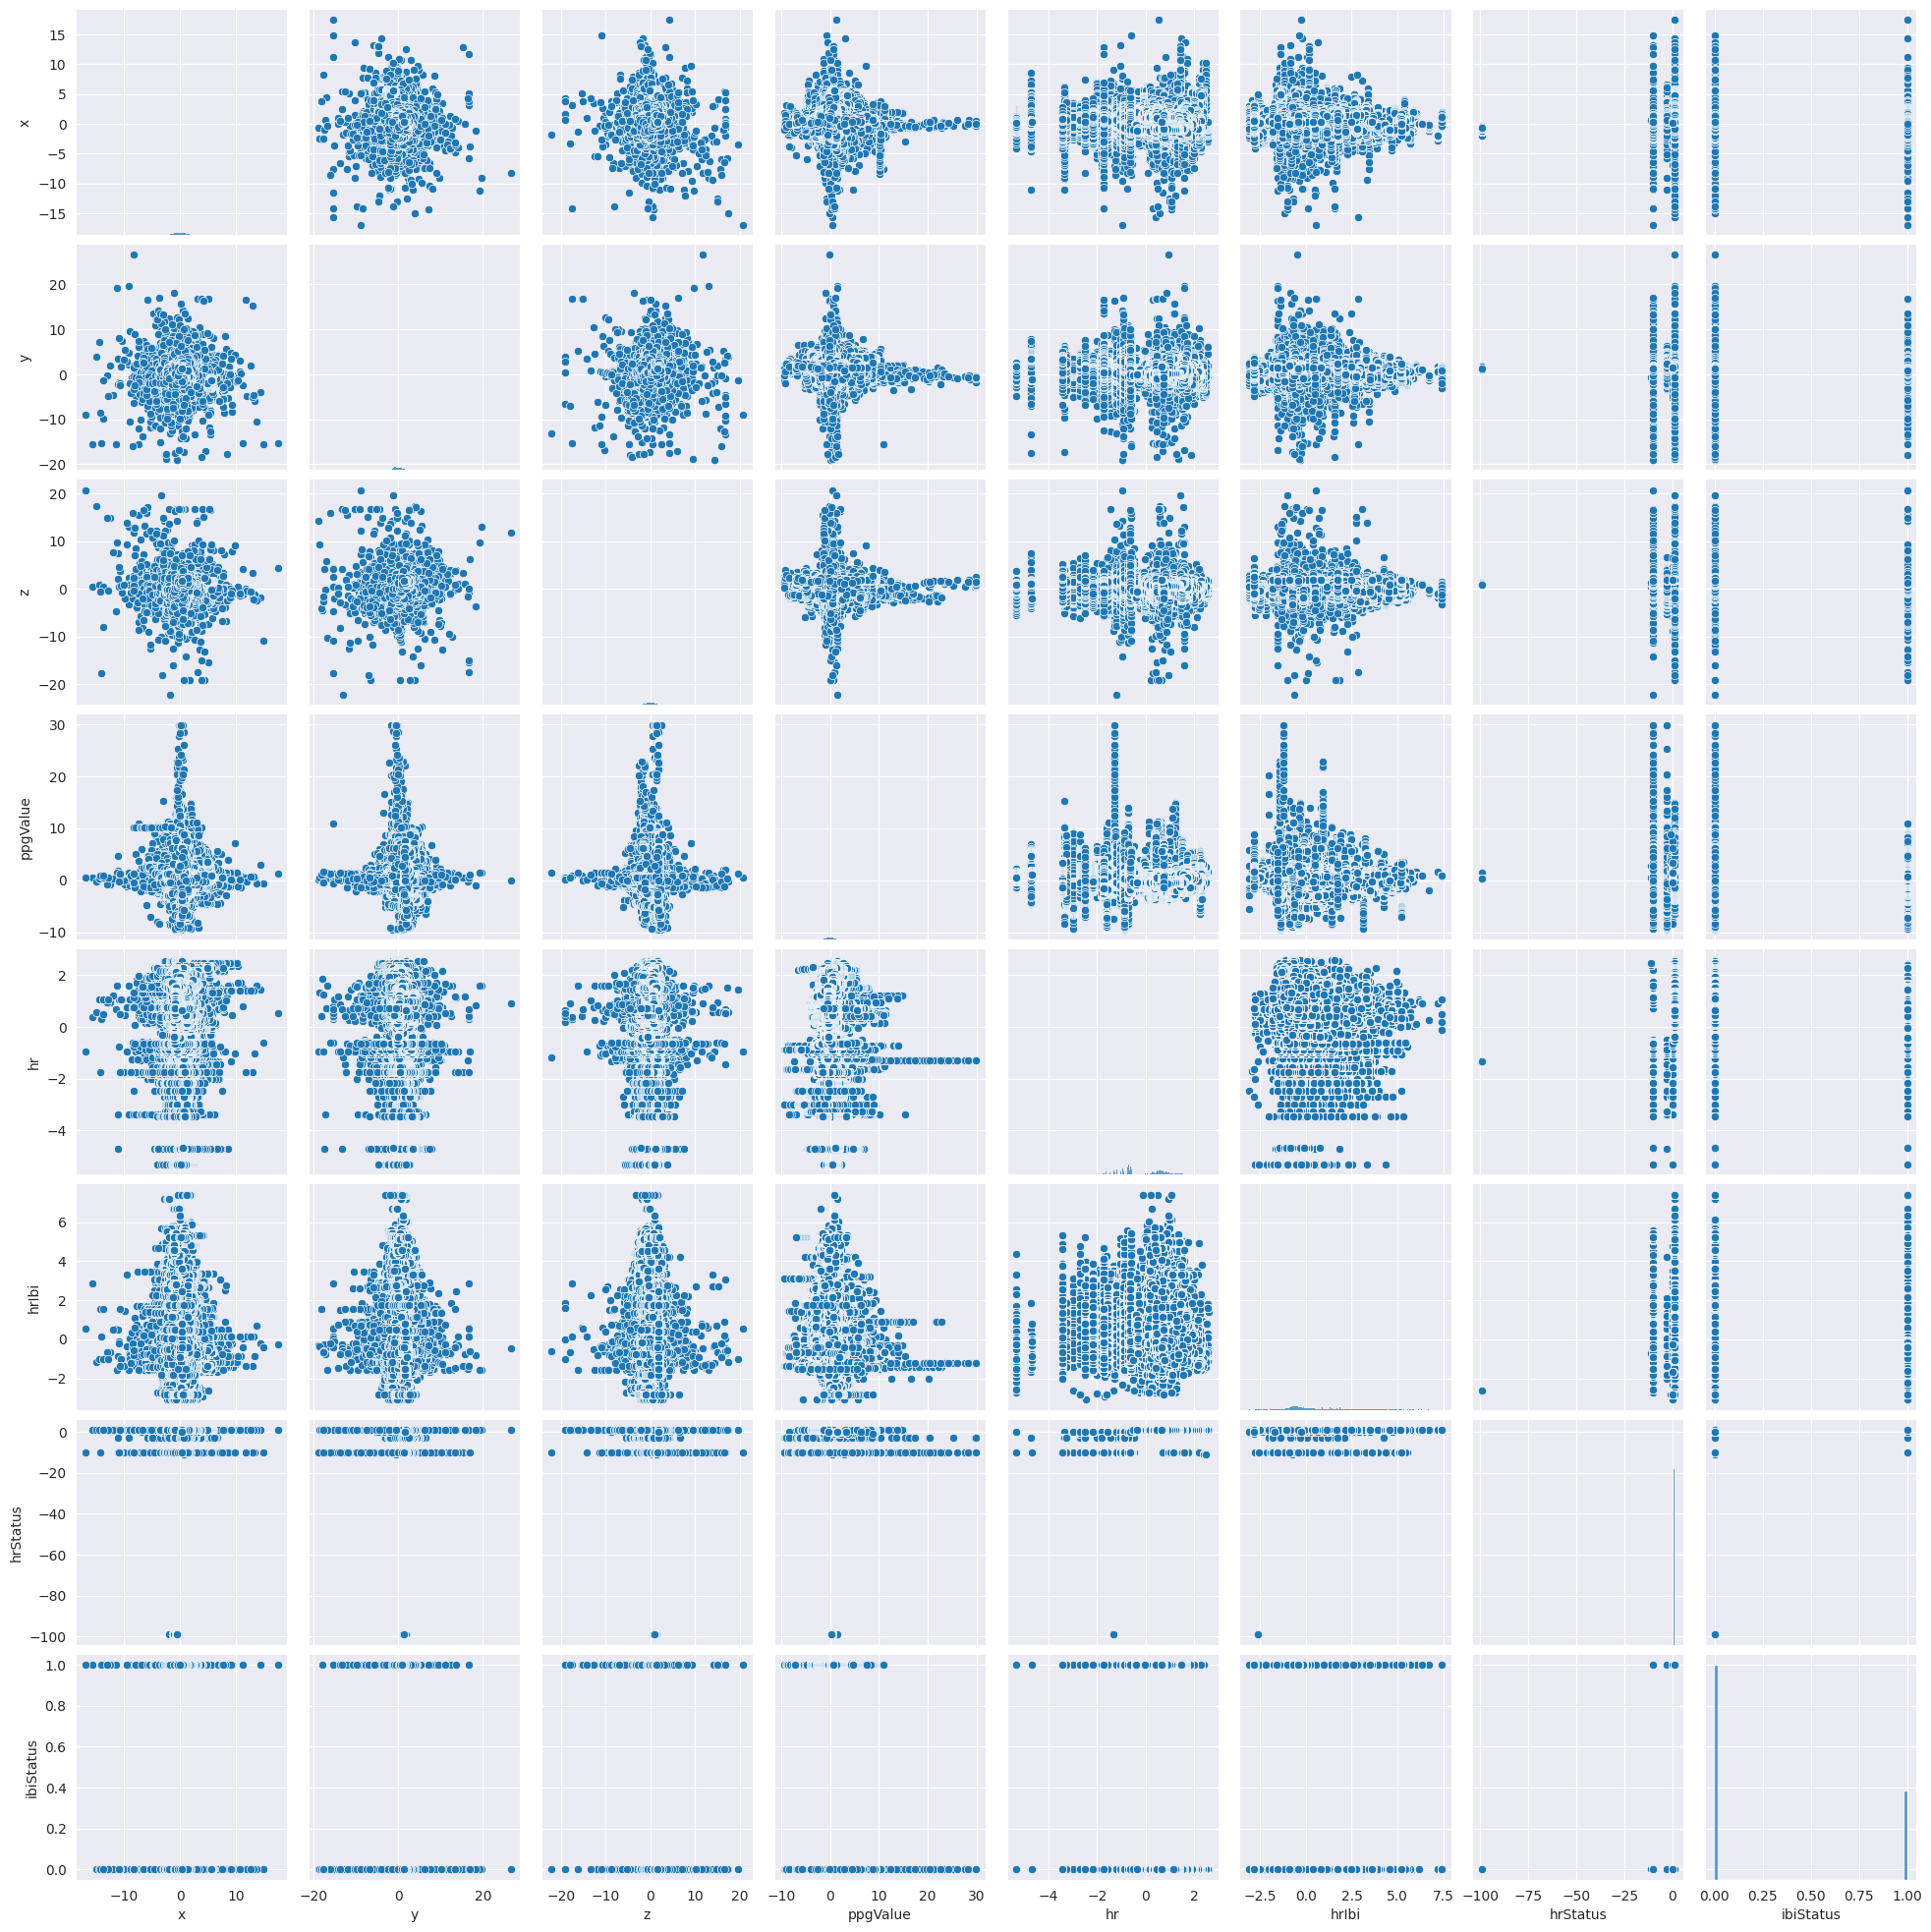

In [4]:
data_encoded = pd.get_dummies(data_cleaned)
columns = ['x', 'y', 'z', 'ppgValue', 'hr', 'hrIbi', 'hrStatus', 'ibiStatus']
sns.pairplot(data_encoded[columns])
plt.show();

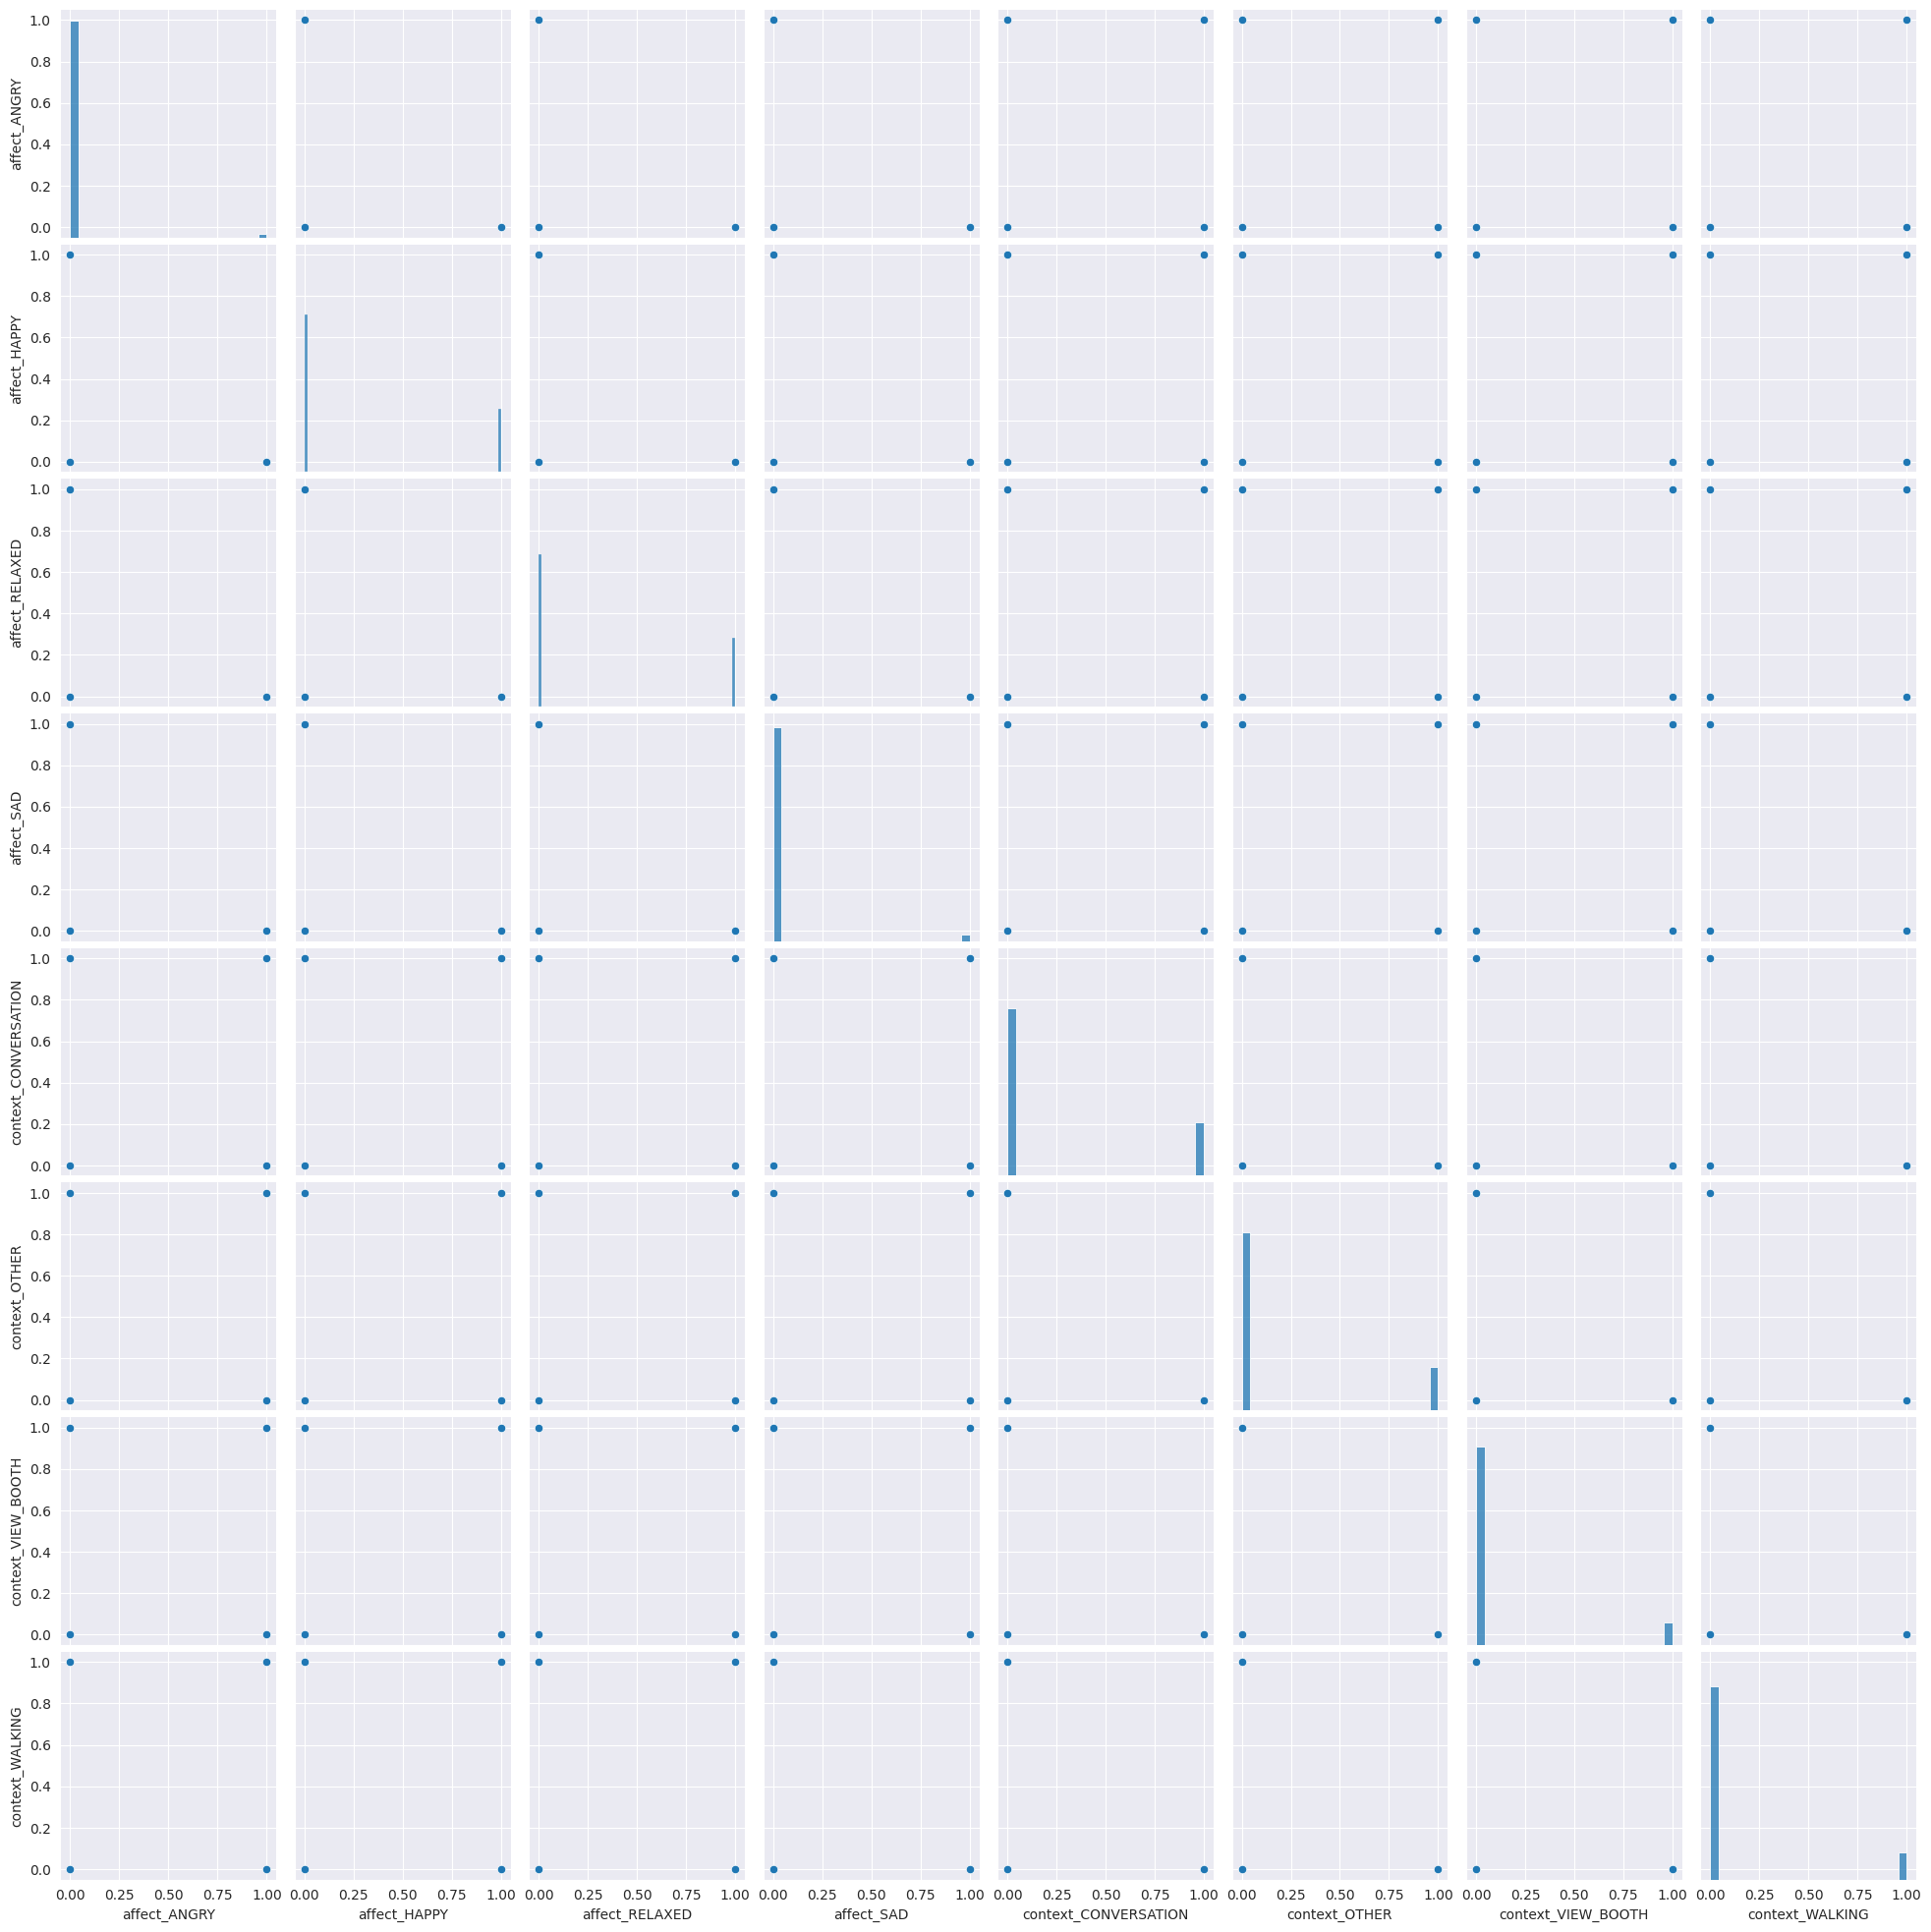

In [12]:
data_encoded = pd.get_dummies(data_cleaned)
#scaler = MinMaxScaler()
#data_normalized = pd.DataFrame(scaler.fit_transform(data_encoded), columns=data_encoded.columns)
columns_labels = ['affect_ANGRY','affect_HAPPY','affect_RELAXED','affect_SAD', 'context_CONVERSATION', 'context_OTHER', 'context_VIEW_BOOTH', 'context_WALKING']
sns.pairplot(data_encoded[columns_labels])
plt.show();